# Frequency mixer : 'Beauty and the Blur'

In [2]:
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt

- Load Image (choosing img of cat)
- Perform 2D Discrete Variable Fourier Transform
- Display the Magnitude Spectra (Normal and dB form)

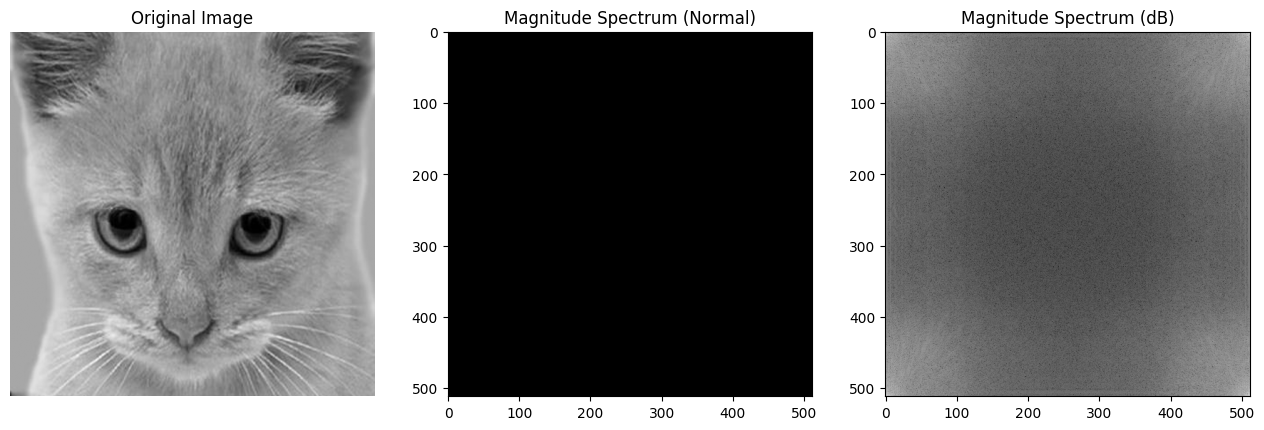

In [3]:
img1 = Image.open('cat_gray.jpg')
img1 = img1.resize((512,512))
img2 = Image.open('dog_gray.jpg')
img2 = img2.resize((512,512))

#Fourier Transform
img1_transform = np.fft.fft2(img1) # computes 2D DFT of img1

# Magnitude Spectrum
# In Normal Form
mag1 = np.abs(img1_transform)
mag_normal = (mag1 - mag1.min())/(mag1.max() - mag1.min())

#In dB Form
mag_dB = 20 * np.log10(mag1+1e-8)

plt.figure(figsize=(16, 8))

plt.subplot(1,3,1)
plt.imshow(img1, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mag_normal, cmap='gray')
plt.title('Magnitude Spectrum (Normal)')

plt.subplot(1,3,3)
plt.imshow(mag_dB, cmap='gray')
plt.title('Magnitude Spectrum (dB)')

plt.show()

Where is the spectrum centered?
- The fourier transform through `fft2` shifts the **zero frequency component** representing **average brightness** at the **corners** of the spectrum,  specifically at the **top left corner**.

The spectrum can be shifted so that the lower frequencies can be centered by using `fftshift`.

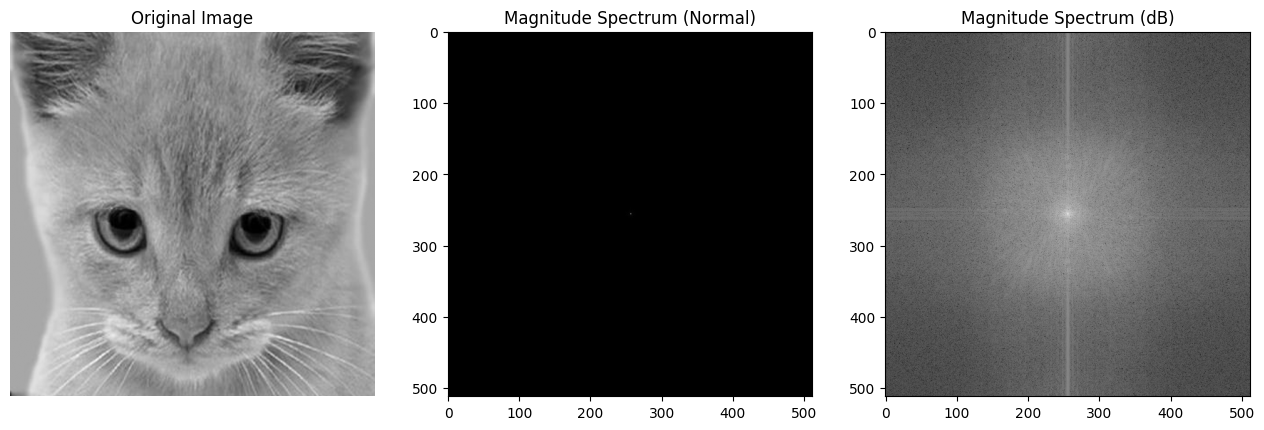

In [4]:
img1_transform_shifted = np.fft.fftshift(img1_transform) # shifting the low frequencies to the centre to infer something from the spectrum

# Magnitude Spectrum
# In Normal Form
mag1 = np.abs(img1_transform_shifted)
mag_normal = (mag1 - mag1.min())/(mag1.max() - mag1.min())

#In dB Form
mag_dB = 20 * np.log10(mag1+1e-8)

plt.figure(figsize=(16, 8))

plt.subplot(1,3,1)
plt.imshow(img1, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mag_normal, cmap='gray')
plt.title('Magnitude Spectrum (Normal)')

plt.subplot(1,3,3)
plt.imshow(mag_dB, cmap='gray')
plt.title('Magnitude Spectrum (dB)')

plt.show()

- Rotating the input image (img1) 90 degrees anticlockwise
- Plotting the magnitude spectra of its 2D fourier discrete transform

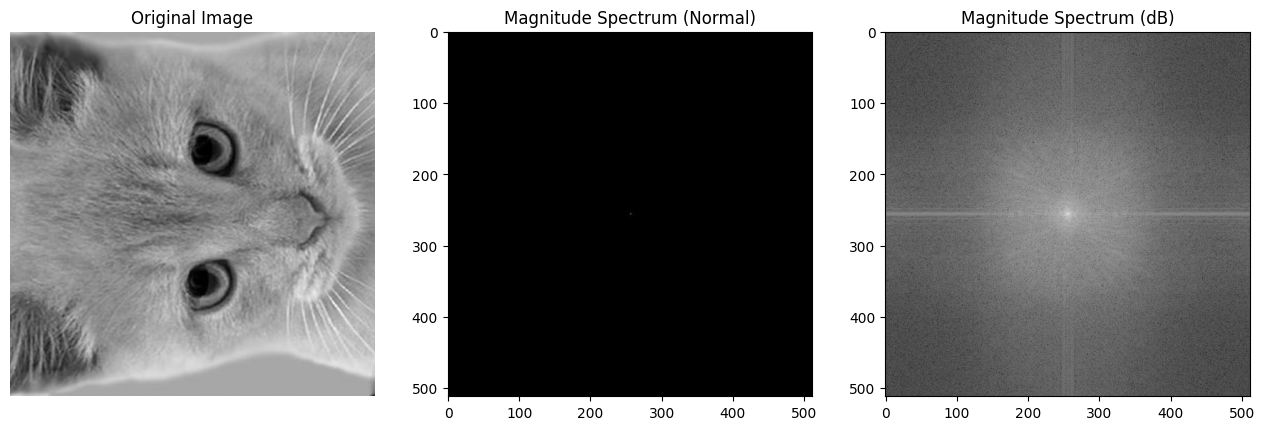

In [5]:
#Rotating input image 90 degree anti-clockwise
img1_rot = img1.rotate(90)

img1_rot_transform = np.fft.fft2(img1_rot) # computes 2D DFT of img1_rot
img1_rot_transform_shifted = np.fft.fftshift(img1_rot_transform) # shifting the low frequencies to the centre to infer something from the spectrum

# Magnitude Spectrum
# In Normal Form
mag1_rot = np.abs(img1_rot_transform_shifted)
mag_normal_rot = (mag1_rot - mag1_rot.min())/(mag1_rot.max() - mag1_rot.min())

#In dB Form
mag_dB_rot = 20 * np.log10(mag1_rot+1e-8)

plt.figure(figsize=(16, 8))

plt.subplot(1,3,1)
plt.imshow(img1_rot, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mag_normal_rot, cmap='gray')
plt.title('Magnitude Spectrum (Normal)')

plt.subplot(1,3,3)
plt.imshow(mag_dB_rot, cmap='gray')
plt.title('Magnitude Spectrum (dB)')

plt.show()

- Comparing the spectra with the original image spectra

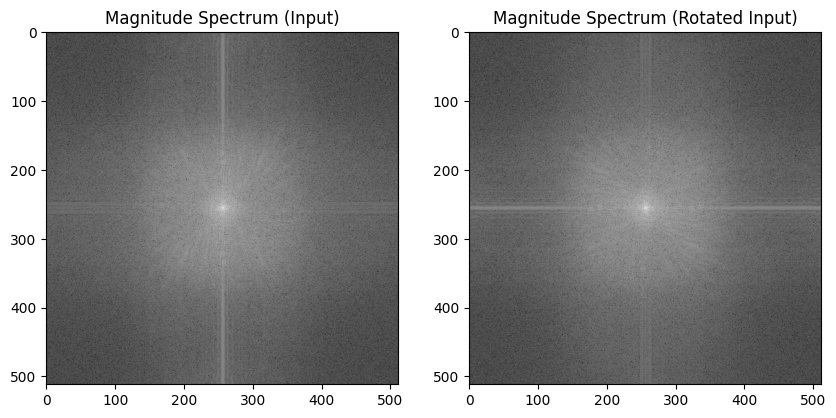

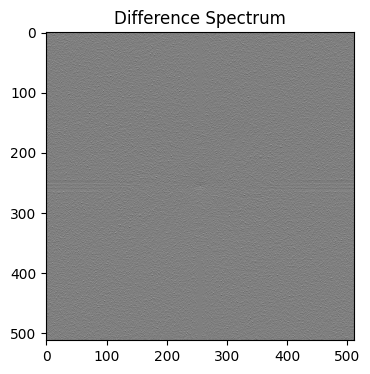

In [6]:
#Comparison of the dB form for the input image and its rotated one
plt.figure(figsize=(10, 6))

plt.subplot(1,2,1)
plt.imshow(mag_dB, cmap='gray')
plt.title('Magnitude Spectrum (Input)')

plt.subplot(1,2,2)
plt.imshow(mag_dB_rot, cmap='gray')
plt.title('Magnitude Spectrum (Rotated Input)')

plt.show()

#rotating the rotated in cloackwise direction and calculating the difference spectrum
mag_dB_rot_rotclk = np.rot90(mag_dB_rot, k=1)

diff_spec = mag_dB - mag_dB_rot_rotclk

plt.figure(figsize=(4, 4))
plt.imshow(diff_spec, cmap='gray')
plt.title('Difference Spectrum')
plt.show()

##### Observations
- The overall pattern of the magnitude spectrum is **preserved** after rotation.
- Every feature in the frequency-domain plot of the rotated image appears **rotated** by exactly **90°** compared to the original spectrum.

## Frequency Mixer
##### Goal : Create a hybrid image by combining low frequencies from the dog image(img2) and high frequencies from the cat image(img1)

**System Design**
1. Apply 2D FFT to both images and shift them(`fftshift`)
2. Create frequency masks:
    - **Low-pass mask**: Keep low frequencies from img2 for defining the **structure**
    - **High-pass mask**: Keep high frequencies from img1 for defininf the **details**
3. Fuse in frequency domain by applying the masks to the respective images
4. **Reconstruction:** perform the inverse FFT (`ifft2`, `ifftshift`) and take magnitude to get the fused image.

In [7]:
# Image for high frequecies
f1 = np.fft.fft2(img1)
f1 = np.fft.fftshift(f1)

# Image for low frequecies
f2 = np.fft.fft2(img2)
f2 = np.fft.fftshift(f2)

**Frequency Masks**

Text(0.5, 1.0, 'Magnitude Spectrum (dB)')

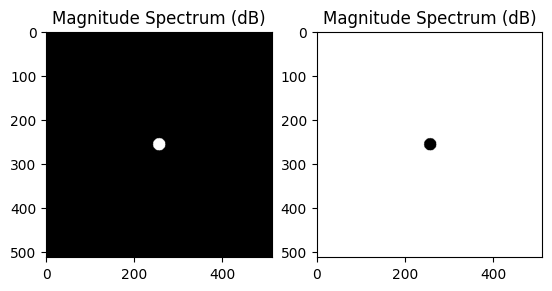

In [18]:
def create_circular_mask(shape, radius):
    center = (shape[0] // 2, shape[1] // 2)
    Y, X = np.ogrid[:shape[0], :shape[1]]
    dist_from_center = np.sqrt((X - center[1])**2 + (Y - center[0])**2)
    return dist_from_center <= radius

mask_low = create_circular_mask(img2.size, radius=14)
mask_high = ~mask_low

mask_low_spec = np.abs(mask_low)
mask_mag = 20 * np.log10(mask_low_spec+1e-8)
plt.subplot(1,2,1)
plt.imshow(mask_mag, cmap='gray')
plt.title('Magnitude Spectrum (dB)')

mask_high_spec = np.abs(mask_high)
mask_mag_h = 20 * np.log10(mask_high_spec+1e-8)
plt.subplot(1,2,2)
plt.imshow(mask_mag_h, cmap='gray')
plt.title('Magnitude Spectrum (dB)')

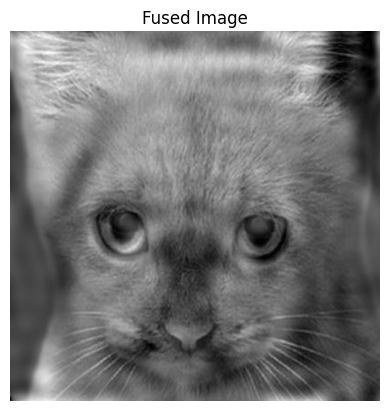

In [24]:
# Fusing the masks to obtain final image
fused = (f2*mask_low) + (f1*mask_high)*0.9

fused = np.fft.ifft2(np.fft.ifftshift(fused))
fused_image = np.abs(fused)

plt.imshow(fused_image, cmap='gray')
plt.title('Fused Image')
plt.axis('off')
plt.show()